# Numerical approximation and convergence speed of PIML methods

## Package

In [ ]:
# Allows to automatically switch from CPU to GPU
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.set_default_dtype(torch.float64)

def is_running_on_gpu():
  if torch.cuda.is_available():
    print("The algorithm is running on GPU.")
  else:
    print("The algorithm is not running on GPU.")

In [ ]:
import pandas as pd

In [ ]:
def save(list1, list2, list3, name):
  pd.DataFrame(data={"a": list1, "b": [i.tolist() for i in list2], "c": [i.tolist() for i in list3]}).to_csv(name+".csv")
  return


### Dimension $d=1$

In [ ]:
def Sob_formula_1d(k, j, s, L):
    return torch.where(k == j, 1+ k**(2*s)/(2*L)**s, 0.)


def Sob_matrix_1d(m, s, L, device):
  fourier_range = torch.arange(-m, m+1, device=device)
  k, j = torch.meshgrid(fourier_range, fourier_range, indexing='ij')
  k = k.flatten()
  j = j.flatten()

  sob_values = Sob_formula_1d(k, j, s, L)

  return sob_values.view(2*m+1, 2*m+1)

In [ ]:
class DifferentialOperator1d:
    def __init__(self, coefficients=None):
        """
        Initialize the PDE.
        The keys are tuples representing the powers of d/dX.
        For example, {(2): 3, (0): -1} represents 3d^2/dX^2 - 1.
        """
        if coefficients is None:
            self.coefficients = {}
        else:
            self.coefficients = coefficients

    def __repr__(self):
        terms = []
        for (x_power), coefficient in sorted(self.coefficients.items(), reverse=True):
            if coefficient == 0:
                continue
            term = f"{coefficient}"
            if x_power != 0:
                term += f"*(d/dX)^{x_power}"
            terms.append(term)
        PDE = " + ".join(terms) if terms else "0"
        return "The PDE of your model is " + PDE + " = 0."

    def __add__(self, other):
        if isinstance(other, (int, float)):
            result = DifferentialOperator1d(self.coefficients.copy())
            if (0) in result.coefficients:
                result.coefficients[(0)] += other
            else:
                result.coefficients[(0)] = other
            return result

        result = DifferentialOperator1d(self.coefficients.copy())
        for (x_power), coefficient in other.coefficients.items():
            if (x_power) in result.coefficients:
                result.coefficients[(x_power)] += coefficient
            else:
                result.coefficients[(x_power)] = coefficient
        return result

    def __radd__(self, other):
        return self.__add__(other)

    def __sub__(self, other):
        result = DifferentialOperator1d(self.coefficients.copy())
        for (x_power), coefficient in other.coefficients.items():
            if (x_power) in result.coefficients:
                result.coefficients[(x_power)] -= coefficient
            else:
                result.coefficients[(x_power)] = -coefficient
        return result

    def __mul__(self, other):
        if isinstance(other, (int, float)):
            result = DifferentialOperator1d()
            for (x_power), coefficient in self.coefficients.items():
                result.coefficients[(x_power)] = coefficient * other
            return result

        result = DifferentialOperator1d()
        for (x1), c1 in self.coefficients.items():
            for (x2), c2 in other.coefficients.items():
                power = (x1 + x2)
                if power in result.coefficients:
                    result.coefficients[power] += c1 * c2
                else:
                    result.coefficients[power] = c1 * c2
        return result

    def __rmul__(self, other):
        return self.__mul__(other)

    def __pow__(self, exponent):
        if exponent == 0:
            return DifferentialOperator1d({(0): 1})
        elif exponent < 0:
            raise ValueError("Exponent must be a non-negative integer")

        result = DifferentialOperator1d(self.coefficients.copy())
        for _ in range(1, exponent):
            result *= self
        return result

    def evaluate(self, x, L):
        total = 0
        geometry = -1j*torch.pi/2/L
        for (x_power), coefficient in self.coefficients.items():
            total += coefficient * (x ** x_power) * (geometry **(x_power))
        return total


In [ ]:
def Fourier_PDE_1d(k, j, L, PDE):
  return torch.where(k == j, PDE.evaluate(k, L), 0.)

def PDE_matrix_1d(m, L, PDE, device):
  fourier_range = torch.arange(-m, m+1, device=device)
  k, j = torch.meshgrid(fourier_range, fourier_range, indexing='ij')
  k = k.flatten()
  j = j.flatten()

  PDE_values = Fourier_PDE_1d(k, j, L, PDE)

  return PDE_values.view(2*m+1, 2*m+1)

In [ ]:
def Omega_matrix_1d(m, device):
  fourier_range = torch.arange(-m, m+1, device=device)
  k, j = torch.meshgrid(fourier_range, fourier_range, indexing='ij')
  k = (k-j).flatten()
  j = None

  T_values = torch.where(k == 0, 1/2, 0.) + torch.where(k != 0, torch.sin(torch.pi*k/2)/k/torch.pi, 0.)


  return T_values.view(2*m+1, 2*m+1)

In [ ]:
def dimension_m_1d(log10_target_dimension_max):
  m_list=[]
  for i in range(1, int(2*log10_target_dimension_max)+1):
    m_list.append(round((10**(i/2)-1)/2))
  return m_list

def Eigenvalues_numerical_1d(log_m_max, lambda_n, mu_n, s, L, PDE, device):
  is_running_on_gpu()

  m_list = dimension_m_1d(log_m_max)

  spectra, xs = [], []

  for m in m_list:
    P = PDE_matrix_1d(m, L, PDE, device)*(1.0+0*1j)
    T = Omega_matrix_1d(m, device)*(1.0+0*1j)
    PTP = torch.transpose(torch.conj_physical(P), 0, 1)@T@P
    del P

    S = Sob_matrix_1d(m, s, L, device)*(1.0+0*1j)
    M = lambda_n * S + mu_n * PTP
    del S

    Mat = torch.transpose(torch.conj_physical(T), 0, 1)@torch.linalg.solve(M,T)
    del M, T

    eigenvalues = torch.linalg.eigvalsh(Mat)

    x = torch.tensor([i+1 for i in range(2*m+1)])
    sorted_eig = torch.log(torch.abs(eigenvalues))

    xs.append(x)
    spectra.append(sorted_eig)

    print(str(2*m+1)+ " Fourier modes, done.")
  return m_list, xs, spectra

import matplotlib.pyplot as plt
import numpy as np

def plot_eigenvalues_1d(m_list, xs, spectra, ymin, ymax, theoretical_bound):
  for i in range(len(m_list)):
    log10 = torch.log(torch.tensor(10))
    x_log10 = torch.log(xs[i])/log10
    spectra_log10 = torch.sort(spectra[i], descending=True)[0]/log10
    m_log10 = round((torch.log(2*torch.tensor(m_list[i])+1)/log10).item(),1)
    plt.scatter(x_log10.tolist(), spectra_log10.tolist(), marker='x', s=10, label="log10(m) = "+str(m_log10), alpha=0.8)
  if theoretical_bound:
    interval = xs[-1].numpy()[3:]
    upper_bound = 4/(lambda_n + mu_n)/(interval-2)**2
    plt.scatter(np.log(interval)/np.log(10), np.log(upper_bound)/np.log(10), marker='+', s=20, label="theoretical upper bound", alpha=0.8)
  plt.legend(loc="lower left")
  plt.xlabel("$log_{10}$(index)")
  plt.ylabel("$log_{10}$(Eigenvalue)")
  plt.title("Eigenvalues decay")

  plt.savefig("fig1.pdf", format="pdf", bbox_inches="tight")
  plt.show()



  for i in range(len(m_list)):
    log10 = torch.log(torch.tensor(10))
    x_log10 = torch.log(xs[i])/log10
    spectra_log10 = torch.sort(spectra[i], descending=True)[0]/log10
    m_log10 = round((torch.log(2*torch.tensor(m_list[i])+1)/log10).item(),1)
    plt.scatter(x_log10.tolist(), spectra_log10.tolist(), marker='x', s=10, label="log10(m) = "+str(m_log10), alpha=0.8)
  if theoretical_bound:
    interval = xs[-1].numpy()[3:]
    upper_bound = 4/(lambda_n + mu_n)/(interval-2)**2
    plt.scatter(np.log(interval)/np.log(10), np.log(upper_bound)/np.log(10), marker='+', s=20, label="theoretical upper bound", alpha=0.8)
  plt.legend(loc="lower left")
  plt.legend(loc="lower left")
  plt.xlabel("$log_{10}$(index)")
  plt.ylabel("$log_{10}$(Eigenvalue)")
  plt.title("Eigenvalues decay")
  plt.ylim(ymin, ymax)

  plt.savefig("fig2.pdf", format="pdf", bbox_inches="tight")
  plt.show()

In [ ]:
def Effective_Dimension_1d(log_m_max, log_n_max, lambda_n_exponent, s, L, PDE, device):
  n_list_m = []
  eff_list_m=[]
  m_list = dimension_m_1d(log_m_max)

  for m in m_list:
    print(str(2*m+1)+ " Fourier modes")
    n_list = []
    eff_list = []

    S = Sob_matrix_1d(m, s, L, device)*(1.0+0*1j)
    P = PDE_matrix_1d(m, L, PDE, device)*(1.0+0*1j)
    T = Omega_matrix_1d(m, device)*(1.0+0*1j)

    for N in range(1, 2*log_n_max +1):
      n = int(10**(N/2))
      n_list.append(torch.log(torch.tensor(n)))

      lambda_n = n**(-lambda_n_exponent)
      mu_n = 1/torch.log(torch.tensor(n))
      M = lambda_n * S + mu_n * torch.transpose(torch.conj_physical(P), 0, 1)@T@P

      TMinvT = torch.transpose(torch.conj_physical(T), 0, 1)@torch.linalg.solve(M,T)
      M = None

      Mat = torch.linalg.solve(TMinvT+torch.eye(2*m+1, device=device), TMinvT)
      TMinvT = None

      eff_list.append(torch.trace(Mat))
      Mat = None

      print(str(N/2/log_n_max*100)+"% done")

    n_list, eff_list = torch.tensor(n_list),  torch.real(torch.tensor(eff_list))

    n_list_m.append(n_list), eff_list_m.append(eff_list)
  return m_list, n_list_m, eff_list_m

def plot_effective_dim_1d(m_list, n_list_m, eff_list_m):
  log10 = torch.log(torch.tensor(10))
  n_log10 = n_list_m[-1]/log10
  eff_log10 = torch.log(eff_list_m[-1])/log10
  m_log10 = round((torch.log(2*torch.tensor(m_list[-1])+1)/log10).item(),1)

  plt.scatter(n_log10, eff_log10)#, label = "log10(m) = "+str(m_log10))
  plt.plot(n_log10, eff_log10)
  plt.xlabel("log10(n)")
  plt.ylabel("log10(Effective dimension)")
  plt.title("Effective dimension N with log(m) = "+str(m_log10))
  plt.legend(loc="lower right")

  plt.savefig("fig3.pdf", format="pdf", bbox_inches="tight")
  plt.show()

def plot_effective_dim_1d2(m_list, n_list_m, eff_list_m):
  log10 = torch.log(torch.tensor(10))
  n_log10 = (torch.round(n_list_m[0]/log10, decimals=1)).tolist()
  m_log10 = torch.round((torch.log(2*torch.tensor(m_list)+1)/log10),decimals=1)#.item()
  m = len(m_list)

  for i in range(len(n_list_m)):
    eff_dim_n = [torch.log(eff_list_m[j])[i]/log10 for j in range(m)]
    plt.scatter(m_log10, eff_dim_n, label = "log10(n) = "+str(n_log10[i]))
    plt.plot(m_log10, eff_dim_n)

  plt.xlabel("log10(m)")
  plt.ylabel("log10(Effective dimension)")
  plt.title("Effective dimension N")
  plt.legend(loc="lower right")

  plt.savefig("fig4.pdf", format="pdf", bbox_inches="tight")
  plt.show()

### Dimension $d=2$

In [ ]:
def Sob_formula(k1, k2, j1, j2, s, L):
    return torch.where(torch.logical_and(k1 == j1, k2 == j2), 1+ (k1**2 + k2**2)**s/(2*L)**(2*s), 0.)


def Sob_matrix(m, s, L, device):
  fourier_range = torch.arange(-m, m+1, device=device)
  k1, k2, j1, j2 = torch.meshgrid(fourier_range, fourier_range, fourier_range, fourier_range, indexing='ij')
  k1 = k1.flatten()
  k2 = k2.flatten()
  j1 = j1.flatten()
  j2 = j2.flatten()

  sob_values = Sob_formula(k1, k2, j1, j2, s, L)

  return sob_values.view((2*m+1)**2, (2*m+1)**2)

In [ ]:
class DifferentialOperator:
    def __init__(self, coefficients=None):
        """
        Initialize the PDE.
        The keys are tuples representing the powers of d/dX and d/dY respectively.
        For example, {(2, 1): 3, (0, 0): -1} represents 3d^2/dX^2 d/dY - 1.
        """
        if coefficients is None:
            self.coefficients = {}
        else:
            self.coefficients = coefficients

    def __repr__(self):
        terms = []
        for (x_power, y_power), coefficient in sorted(self.coefficients.items(), reverse=True):
            if coefficient == 0:
                continue
            term = f"{coefficient}"
            if x_power != 0:
                term += f"*(d/dX)^{x_power}"
            if y_power != 0:
                term += f"*(d/dY)^{y_power}"
            terms.append(term)
        PDE = " + ".join(terms) if terms else "0"
        return "The PDE of your model is " + PDE + " = 0."

    def __add__(self, other):
        if isinstance(other, (int, float)):
            result = DifferentialOperator(self.coefficients.copy())
            if (0, 0) in result.coefficients:
                result.coefficients[(0, 0)] += other
            else:
                result.coefficients[(0, 0)] = other
            return result

        result = DifferentialOperator(self.coefficients.copy())
        for (x_power, y_power), coefficient in other.coefficients.items():
            if (x_power, y_power) in result.coefficients:
                result.coefficients[(x_power, y_power)] += coefficient
            else:
                result.coefficients[(x_power, y_power)] = coefficient
        return result

    def __radd__(self, other):
        return self.__add__(other)

    def __sub__(self, other):
        result = DifferentialOperator(self.coefficients.copy())
        for (x_power, y_power), coefficient in other.coefficients.items():
            if (x_power, y_power) in result.coefficients:
                result.coefficients[(x_power, y_power)] -= coefficient
            else:
                result.coefficients[(x_power, y_power)] = -coefficient
        return result

    def __mul__(self, other):
        if isinstance(other, (int, float)):
            result = DifferentialOperator()
            for (x_power, y_power), coefficient in self.coefficients.items():
                result.coefficients[(x_power, y_power)] = coefficient * other
            return result

        result = DifferentialOperator()
        for (x1, y1), c1 in self.coefficients.items():
            for (x2, y2), c2 in other.coefficients.items():
                power = (x1 + x2, y1 + y2)
                if power in result.coefficients:
                    result.coefficients[power] += c1 * c2
                else:
                    result.coefficients[power] = c1 * c2
        return result

    def __rmul__(self, other):
        return self.__mul__(other)

    def __pow__(self, exponent):
        if exponent == 0:
            return DifferentialOperator({(0, 0): 1})
        elif exponent < 0:
            raise ValueError("Exponent must be a non-negative integer")

        result = DifferentialOperator(self.coefficients.copy())
        for _ in range(1, exponent):
            result *= self
        return result

    def evaluate(self, x, y, L):
        total = 0
        geometry = -1j*torch.pi/2/L
        for (x_power, y_power), coefficient in self.coefficients.items():
            total += coefficient * (x ** x_power) * (y ** y_power) * (geometry **(x_power + y_power))
        return total


In [ ]:
def Fourier_PDE(k1, k2, j1, j2, L, PDE):
  return torch.where(torch.logical_and(k1 == j1, k2 == j2), PDE.evaluate(k1,k2, L), 0.)

def PDE_matrix(m, L, PDE, device):
  fourier_range = torch.arange(-m, m+1, device=device)
  k1, k2, j1, j2 = torch.meshgrid(fourier_range, fourier_range, fourier_range, fourier_range, indexing='ij')
  k1 = k1.flatten()
  k2 = k2.flatten()
  j1 = j1.flatten()
  j2 = j2.flatten()

  PDE_values = Fourier_PDE(k1, k2, j1, j2, L, PDE)

  return PDE_values.view((2*m+1)**2, (2*m+1)**2)

In [ ]:
def Omega_matrix(domain, m, device):
  if domain == "square":
    fourier_range = torch.arange(-m, m+1, device=device)
    k1, k2, j1, j2 = torch.meshgrid(fourier_range, fourier_range, fourier_range, fourier_range, indexing='ij')
    k1 = (k1-j1).flatten()
    k2 = (k2-j2).flatten()
    j1, j2 = None, None

    T_values =  torch.mul(torch.sinc(k1/2), torch.sinc(k2/2))/4

    return T_values.view((2*m+1)**2, (2*m+1)**2)
  elif domain == "disk":
    fourier_range = torch.arange(-m, m+1, device=device)
    k1, k2, j1, j2 = torch.meshgrid(fourier_range, fourier_range, fourier_range, fourier_range, indexing='ij')
    k1 = (k1-j1).flatten()
    k2 = (k2-j2).flatten()
    j1, j2 = None, None

    T_values = torch.where(torch.logical_or(k1!= 0, k2 != 0),
                           torch.special.bessel_j1(torch.pi/2*torch.sqrt(k1**2+k2**2))/4/torch.sqrt(k1**2+k2**2), torch.pi/16)
    return T_values.view((2*m+1)**2, (2*m+1)**2)

In [ ]:
def dimension_m(log10_target_dimension_max):
  m_list=[]
  for i in range(1, int(2*log10_target_dimension_max)+1):
    m_list.append(round((10**(i/4)-1)/2))
  return m_list

def Eigenvalues_numerical(log_m_max, lambda_n, mu_n, s, L, domain, PDE, device):
  is_running_on_gpu()

  m_list = dimension_m(log_m_max)

  spectra, xs = [], []

  for m in m_list:
    P = PDE_matrix(m, L, PDE, device)*(1.0+0*1j)
    T = Omega_matrix(domain, m, device)*(1.0+0*1j)
    PTP = torch.transpose(torch.conj_physical(P), 0, 1)@T@P
    del P

    S = Sob_matrix(m, s, L, device)*(1.0+0*1j)
    M = lambda_n * S + mu_n * PTP
    del S

    Mat = torch.transpose(torch.conj_physical(T), 0, 1)@torch.linalg.solve(M,T)
    del M, T

    eigenvalues = torch.linalg.eigvalsh(Mat)

    x = torch.tensor([i+1 for i in range((2*m+1)**2)])
    sorted_eig = torch.log(torch.abs(eigenvalues))

    xs.append(x)
    spectra.append(sorted_eig)

    print(str((2*m+1)**2)+ " Fourier modes, done.")
  return m_list, xs, spectra

import matplotlib.pyplot as plt

def plot_eigenvalues(m_list, xs, spectra, ymin, ymax):
  for i in range(len(m_list)):
    log10 = torch.log(torch.tensor(10))
    x_log10 = torch.log(xs[i])/log10
    spectra_log10 = torch.sort(spectra[i], descending=True)[0]/log10
    m_log10 = round((torch.log((2*torch.tensor(m_list[i])+1)**2)/log10).item(),1)
    plt.scatter(x_log10.tolist(), spectra_log10.tolist(), marker='x', s=10, label="log10(m) = "+str(m_log10))
  plt.legend(loc="lower left")
  plt.xlabel("$log_{10}$(index)")
  plt.ylabel("$log_{10}$(Eigenvalue)")
  plt.title("Eigenvalues decay")
  plt.savefig("fig1.pdf", format="pdf", bbox_inches="tight")
  plt.show()


  for i in range(len(m_list)):
    log10 = torch.log(torch.tensor(10))
    x_log10 = torch.log(xs[i])/log10
    spectra_log10 = torch.sort(spectra[i], descending=True)[0]/log10
    m_log10 = round((torch.log((2*torch.tensor(m_list[i])+1)**2)/log10).item(),1)
    plt.scatter(x_log10.tolist(), spectra_log10.tolist(), marker='x', s=10, label="log10(m) = "+str(m_log10))
  plt.legend(loc="lower left")
  plt.legend(loc="lower left")
  plt.xlabel("$log_{10}$(index)")
  plt.ylabel("$log_{10}$(Eigenvalue)")
  plt.title("Eigenvalues decay")
  plt.ylim(ymin, ymax)
  plt.savefig("fig2.pdf", format="pdf", bbox_inches="tight")
  plt.show()

In [ ]:
def Effective_Dimension(log_m_max, log_n_max, lambda_n_exponent, s, L, domain, PDE, device):
  n_list_m = []
  eff_list_m=[]
  m_list = dimension_m(log_m_max)

  for m in m_list:
    print(str((2*m+1)**2)+ " Fourier modes")
    n_list = []
    eff_list = []

    S = Sob_matrix(m, s, L, device)*(1.0+0*1j)
    P = PDE_matrix(m, L, PDE, device)*(1.0+0*1j)
    T = Omega_matrix(domain, m, device)*(1.0+0*1j)

    for N in range(1, 2*log_n_max +1):
      n = int(10**(N/2))
      n_list.append(torch.log(torch.tensor(n)))

      lambda_n = n**(-lambda_n_exponent)
      mu_n = 1/torch.log(torch.tensor(n))
      M = lambda_n * S + mu_n * torch.transpose(torch.conj_physical(P), 0, 1)@T@P

      TMinvT = torch.transpose(torch.conj_physical(T), 0, 1)@torch.linalg.solve(M,T)
      M = None

      Mat = torch.linalg.solve(TMinvT+torch.eye((2*m+1)**2, device=device), TMinvT)
      TMinvT = None

      eff_list.append(torch.trace(Mat))
      Mat = None

      print(str(N/2/log_n_max*100)+"% done")

    n_list, eff_list = torch.tensor(n_list),  torch.real(torch.tensor(eff_list))

    n_list_m.append(n_list), eff_list_m.append(eff_list)
  return m_list, n_list_m, eff_list_m

def plot_effective_dim(m_list, n_list_m, eff_list_m):
  for i in range(len(m_list)):
    log10 = torch.log(torch.tensor(10))
    n_log10 = n_list_m[i]/log10
    eff_log10 = torch.log(eff_list_m[i])/log10
    m_log10 = round((torch.log((2*torch.tensor(m_list[i])+1)**2)/log10).item(),1)

    plt.scatter(n_log10, eff_log10, label = "log10(m) = "+str(m_log10))
    plt.plot(n_log10, eff_log10)
  plt.xlabel("log10(n)")
  plt.ylabel("log10(Effective dimension)")
  plt.legend(loc="lower right")
  plt.savefig("fig3.pdf", format="pdf", bbox_inches="tight")

  plt.show()



### Deterministic Fourier features $d=2$

In [ ]:
def phi_matrix(mat_x, mat_y, mat_j1, mat_j2, L):
  return torch.exp(torch.pi/L*(torch.mul(mat_x, mat_j1)+torch.mul(mat_y, mat_j2))*1j/2)

def M_mat(s, m, lambda_n, mu_n, L, domain, PDE, device):
  S = Sob_matrix(m, s, L, device)*(1.0+0*1j)
  P = PDE_matrix(m, L, PDE, device)*(1.0+0*1j)
  T = Omega_matrix(domain, m, device)*(1.0+0*1j)
  M = lambda_n * S + mu_n * torch.transpose(torch.conj_physical(P), 0, 1)@T@P
  return M

def RFF_fit(data_t, data_x, data_y, s, m, lambda_n, mu_n, L, domain, PDE, device):
  M = M_mat(s, m, lambda_n, mu_n, L, domain, PDE, device)
  return RFF(m, data_t, data_x, data_y, L,  M, device)


def RFF(m, data_t, data_x, data_y, L, M, device):
  l = len(data_x)

  mat_t = torch.tile(data_t, ((2*m+1)**2,1))
  mat_x = torch.tile(data_x, ((2*m+1)**2,1))

  fourier_range = torch.arange(-m, m+1, device=device)
  fourier_rangex = torch.arange(l, device=device)

  j1, j2,  k1 = torch.meshgrid( fourier_range, fourier_range, fourier_rangex, indexing='ij')
  j1 = j1.flatten().view((2*m+1)**2, l)
  j2 = j2.flatten().view((2*m+1)**2, l)

  phi_mat = phi_matrix(mat_t, mat_x, j1, j2, L)

  # RFF_mat = torch.conj_physical(phi_mat)@torch.transpose(phi_mat, 0, 1)
  # data_y = data_y*(1.+0*1j)
  # return torch.linalg.solve(RFF_mat+l*M, torch.conj_physical(phi_mat)@data_y)

  RFF_mat = phi_mat@torch.conj_physical(torch.transpose(phi_mat, 0, 1))
  data_y = data_y*(1.+0*1j)
  return torch.linalg.solve(RFF_mat+l*M, phi_mat@data_y)



def phi_z_mat(m, data_zt, data_zx, L, device):
  l2 = len(data_zx)
  mat_zt = torch.tile(data_zt, ((2*m+1)**2,1))
  mat_zx = torch.tile(data_zx, ((2*m+1)**2,1))
  fourier_range = torch.arange(-m, m+1, device=device)
  fourier_rangez = torch.arange(l2, device=device)
  jz1, jz2, k1, = torch.meshgrid(fourier_range, fourier_range, fourier_rangez,  indexing='ij')
  jz1 = jz1.flatten().view((2*m+1)**2, l2)
  jz2 = jz2.flatten().view((2*m+1)**2, l2)

  phi_z = phi_matrix(mat_zt, mat_zx, jz1, jz2, L)
  return phi_z


def RFF_estimate(regression_vect, data_zt, data_zx, s, m, n, lambda_n, mu_n, L, domain, PDE, device):
  phi_z = phi_z_mat(m, data_zt, data_zx, L, device)
  estimator = torch.transpose(torch.conj_physical(phi_z), 0,1)@regression_vect
  return estimator

## Effective dimension computations

### The case $d=1$, $D = \frac{d}{dx}$

The algorithm is running on GPU.
3 Fourier modes, done.
9 Fourier modes, done.
31 Fourier modes, done.
101 Fourier modes, done.
317 Fourier modes, done.
1001 Fourier modes, done.
3163 Fourier modes, done.
10001 Fourier modes, done.


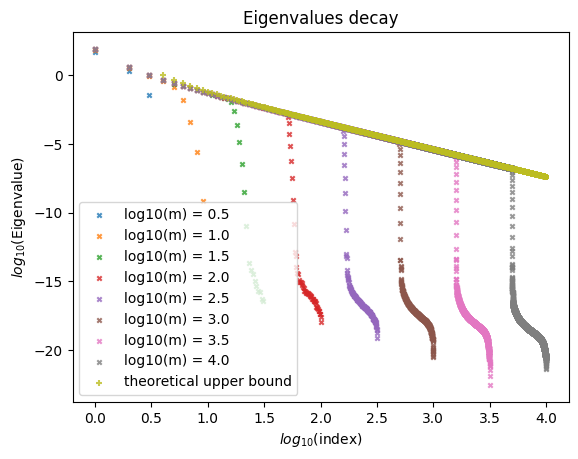

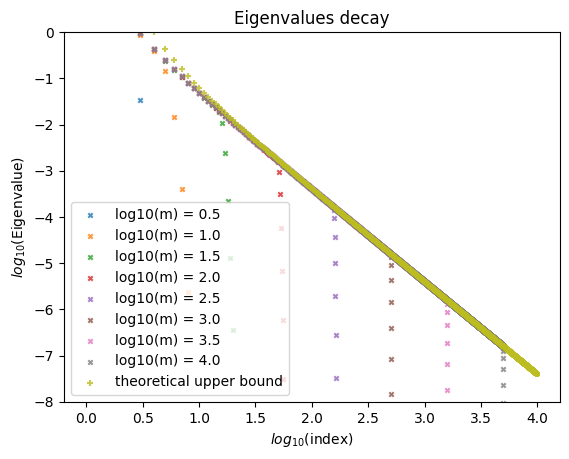

In [ ]:
s = 1
L = torch.pi

dX = DifferentialOperator1d({(1): 1})
PDE = dX

log_m_max = 4 #on GPU, log = 4 takes 1min
lambda_n, mu_n = 0.01, 1

m_list, xs, spectra = Eigenvalues_numerical_1d(log_m_max, lambda_n, mu_n, s, L, PDE, device)
plot_eigenvalues_1d(m_list, xs, spectra, ymin = -8, ymax =0, theoretical_bound=True)
save(m_list, xs, spectra, "spectrum_dx")

3 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
9 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
31 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
101 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
317 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
1001 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
3163 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
10001 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done


100.0% done


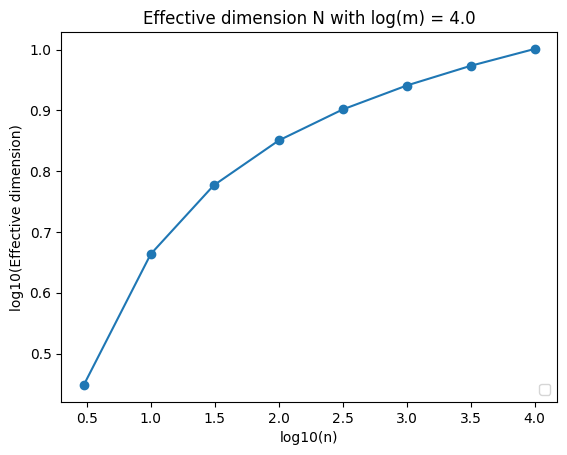

In [ ]:
log_m_max = 4 #3.5 runs in 1min on GPU / 4 in 15min
m_list, n_list_m, eff_list_m = Effective_Dimension_1d(log_m_max, 4, 1, s, L, PDE, device)
plot_effective_dim_1d(m_list, n_list_m, eff_list_m)
save(m_list, n_list_m, eff_list_m, "eff_dim_dx")

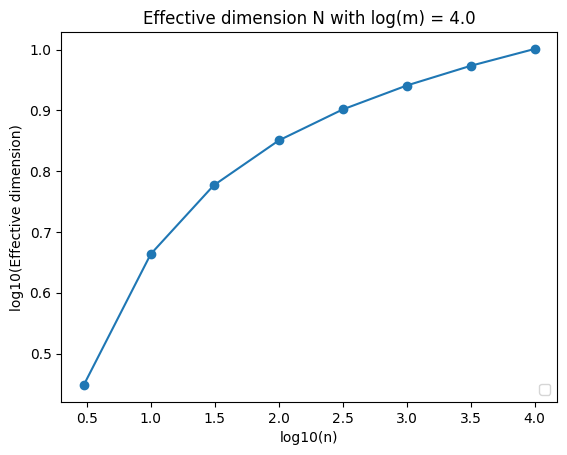

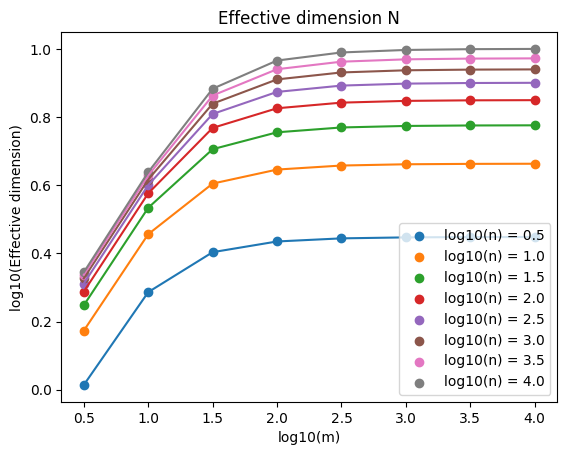

In [ ]:
plot_effective_dim_1d(m_list, n_list_m, eff_list_m)
plot_effective_dim_1d2(m_list, n_list_m, eff_list_m)

### Harmonic oscillator

Here: $d=1, s=2, D(u) = d^2/dx^2 u + d/dx u + u$, $\Omega = [-\pi, \pi]$ et $L=\pi$.

The algorithm is running on GPU.
3 Fourier modes, done.
9 Fourier modes, done.
31 Fourier modes, done.
101 Fourier modes, done.
317 Fourier modes, done.
1001 Fourier modes, done.
3163 Fourier modes, done.
10001 Fourier modes, done.


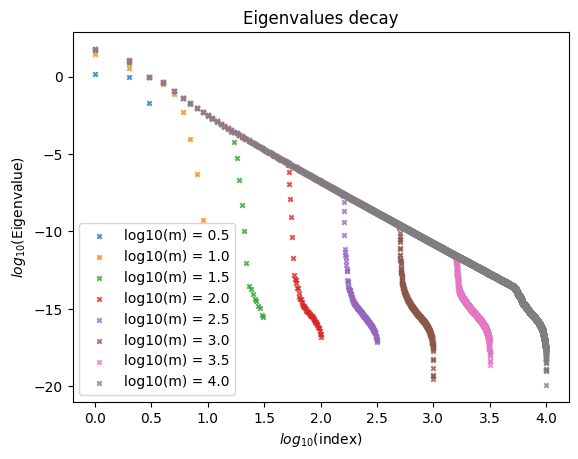

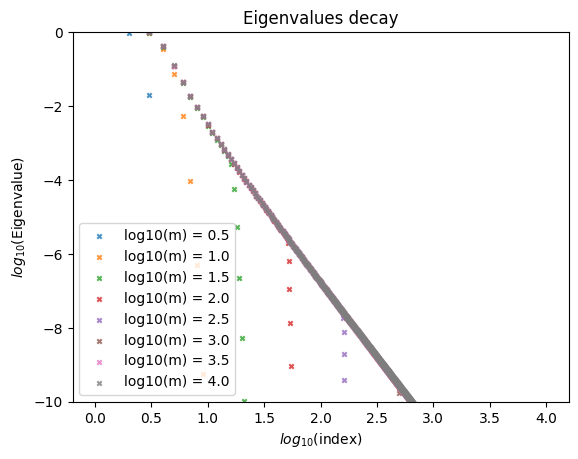

In [ ]:
s = 2
L = torch.pi

dX = DifferentialOperator1d({(1): 1})
PDE = dX**2 + dX +1

log_m_max = 4 #on GPU, log = 4 takes 30 seconds
lambda_n, mu_n = 0.01, 1

m_list, xs, spectra = Eigenvalues_numerical_1d(log_m_max, lambda_n, mu_n, s, L, PDE, device)
plot_eigenvalues_1d(m_list, xs, spectra, ymin = -10, ymax =0, theoretical_bound=False)
save(m_list, xs, spectra, "spectrum_oscillator")

3 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
9 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
31 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
101 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
317 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
1001 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
3163 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
10001 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done


100.0% done


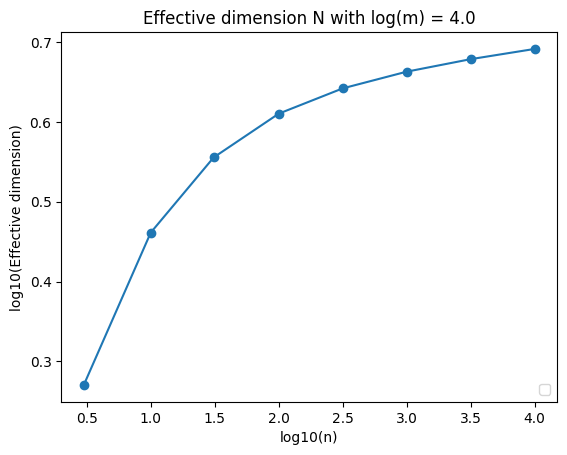

In [ ]:
log_m_max = 4 #4 runs in 1min on GPU
m_list, n_list_m, eff_list_m = Effective_Dimension_1d(log_m_max, 4, 1, s, L, PDE, device)
plot_effective_dim_1d(m_list, n_list_m, eff_list_m)
save(m_list, n_list_m, eff_list_m, "eff_dim_oscillator")

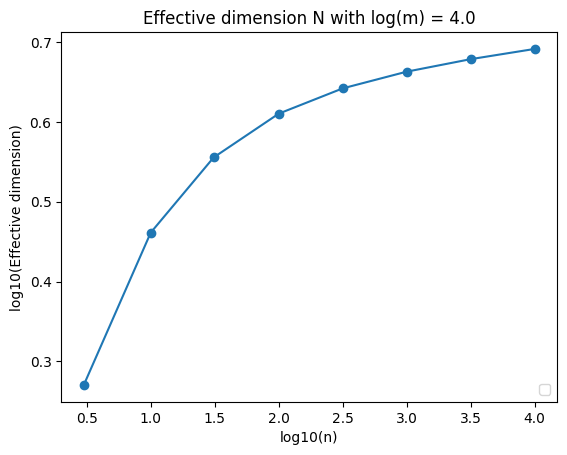

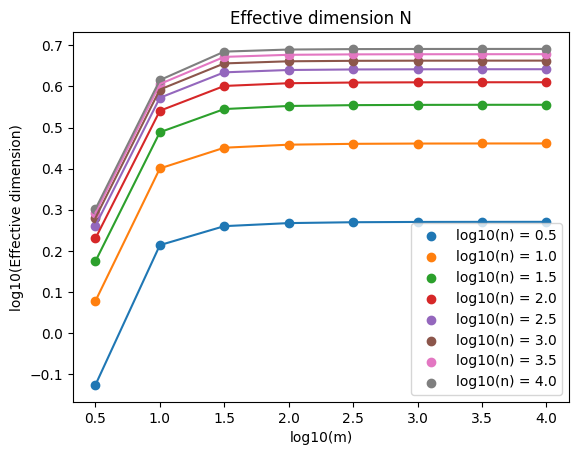

In [ ]:
plot_effective_dim_1d(m_list, n_list_m, eff_list_m)
plot_effective_dim_1d2(m_list, n_list_m, eff_list_m)

### Sobolev learning in 2d

The algorithm is running on GPU.
1 Fourier modes, done.
9 Fourier modes, done.
25 Fourier modes, done.
81 Fourier modes, done.
289 Fourier modes, done.
961 Fourier modes, done.
3249 Fourier modes, done.
10201 Fourier modes, done.


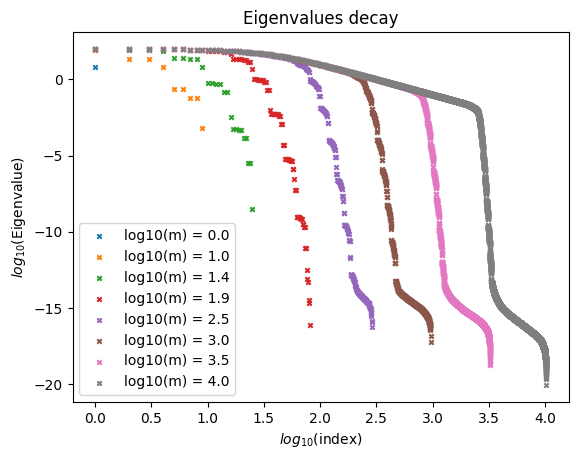

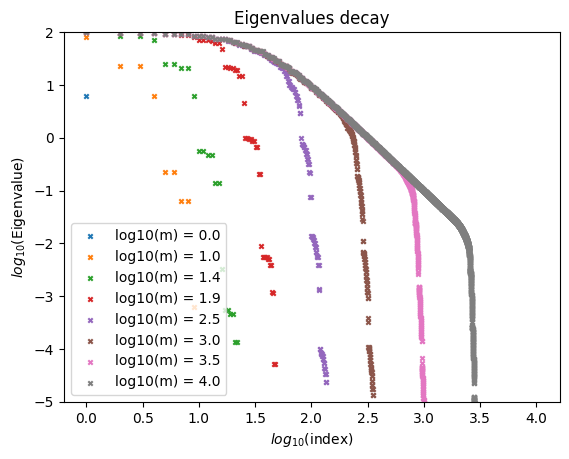

In [ ]:
s = 2
L = torch.pi
domain =  "square"

zero = DifferentialOperator({(0,0): 0})
PDE = zero

log_m_max = 4 #Sur GPU, log = 4 tourne en moins de 20 secondes, 4.5 dépasse la mémoire RAM de 7 giga
lambda_n, mu_n = 1/100, 1

m_list, xs, spectra = Eigenvalues_numerical(log_m_max, lambda_n, mu_n, s, L, domain, PDE, device)
plot_eigenvalues(m_list, xs, spectra, ymin = -5, ymax =2)

1 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
9 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
25 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
81 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
289 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
961 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
3249 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
10201 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done


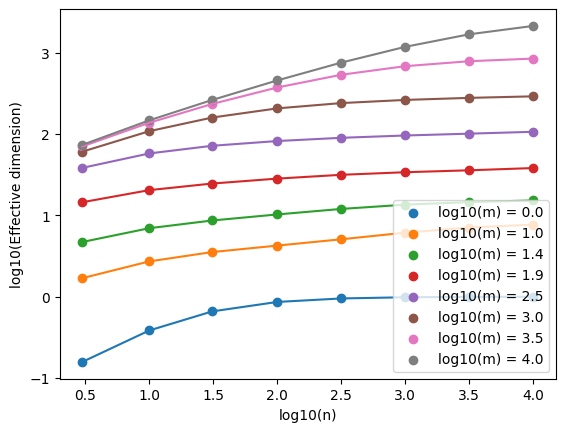

In [ ]:
log_m_max = 4 #4 runs in 1min on GPU
m_list, n_list_m, eff_list_m = Effective_Dimension(log_m_max, 4, 1, s, L, domain, PDE, device)
plot_effective_dim(m_list, n_list_m, eff_list_m)

### Heat equation on smooth domain

The algorithm is running on GPU.
1 Fourier modes, done.
9 Fourier modes, done.
25 Fourier modes, done.
81 Fourier modes, done.
289 Fourier modes, done.
961 Fourier modes, done.
3249 Fourier modes, done.
10201 Fourier modes, done.


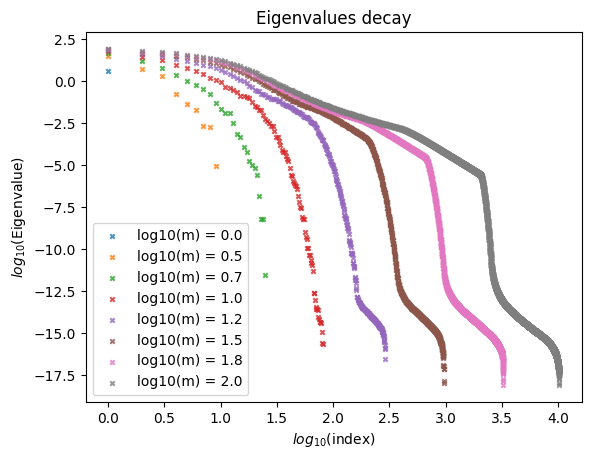

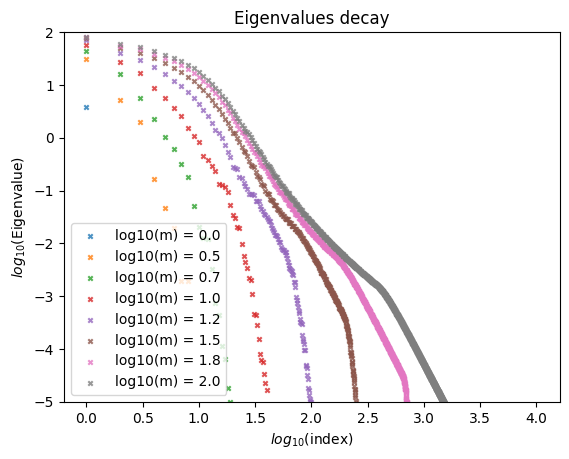

In [ ]:
s = 2
L = torch.pi
domain =  "disk"

dX = DifferentialOperator({(1, 0): 1})
dY = DifferentialOperator({(0, 1): 1})
PDE = dX - dY**2

log_m_max = 4 #Sur GPU, log = 4 tourne en moins de 20 secondes, 4.5 dépasse la mémoire RAM de 7 giga
lambda_n, mu_n = 1/100, 1

m_list, xs, spectra = Eigenvalues_numerical(log_m_max, lambda_n, mu_n, s, L, domain, PDE, device)
plot_eigenvalues_1d(m_list, xs, spectra, ymin = -5, ymax =2, theoretical_bound=False)
save(m_list, xs, spectra, "spectrum_heat_disk")

1 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
9 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
25 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
81 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
289 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
961 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
3249 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
10201 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done


100.0% done


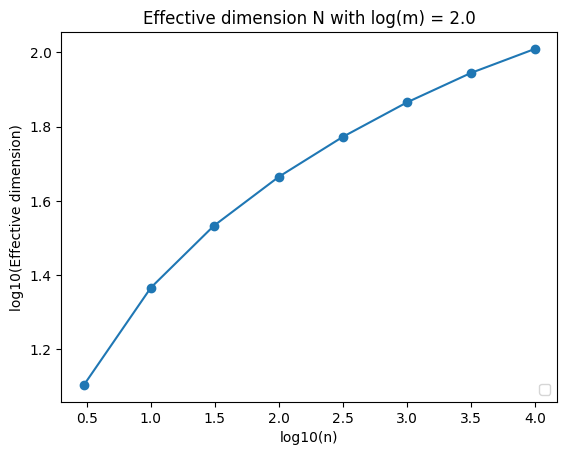

In [ ]:
log_m_max = 4 #4 runs in 1min on GPU
m_list, n_list_m, eff_list_m = Effective_Dimension(log_m_max, 4, 1, s, L, domain, PDE, device)
#plot_effective_dim(m_list, n_list_m, eff_list_m)
plot_effective_dim_1d(m_list, n_list_m, eff_list_m)
save(m_list, n_list_m, eff_list_m, "eff_dim_heat_disk")

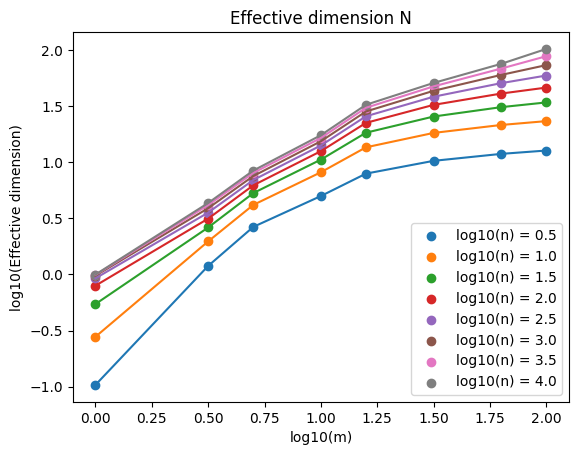

In [ ]:
plot_effective_dim_1d2(m_list, n_list_m, eff_list_m)

### Heat equation on non-smooth domain

The algorithm is running on GPU.
1 Fourier modes, done.
9 Fourier modes, done.
25 Fourier modes, done.
81 Fourier modes, done.
289 Fourier modes, done.
961 Fourier modes, done.
3249 Fourier modes, done.
10201 Fourier modes, done.


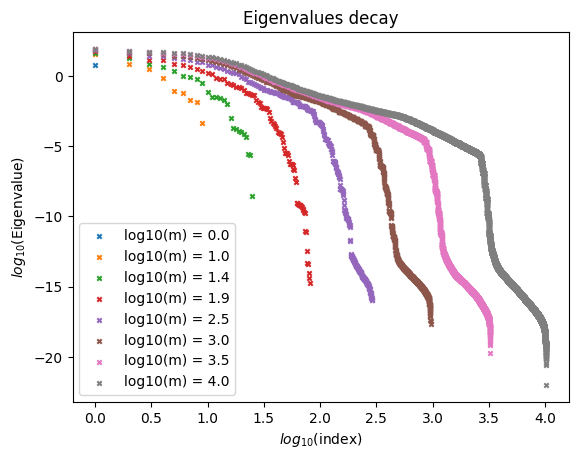

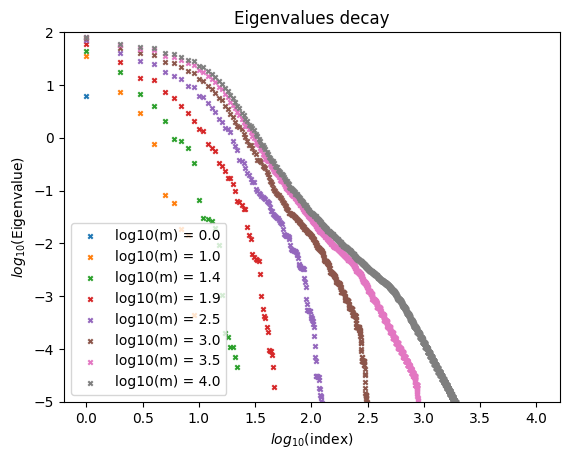

In [ ]:
s = 2
L = torch.pi
domain =  "square"

dX = DifferentialOperator({(1, 0): 1})
dY = DifferentialOperator({(0, 1): 1})
PDE = dX - dY**2

log_m_max = 4 #Sur GPU, log = 4 tourne en moins de 20 secondes, 4.5 dépasse la mémoire RAM de 7 giga
lambda_n, mu_n = 1/100, 1

m_list, xs, spectra = Eigenvalues_numerical(log_m_max, lambda_n, mu_n, s, L, domain, PDE, device)
plot_eigenvalues(m_list, xs, spectra, ymin = -5, ymax =2)
save(m_list, xs, spectra, "spectrum_heat_sq")

1 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
9 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
25 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
81 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
289 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
961 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
3249 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
10201 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done


100.0% done


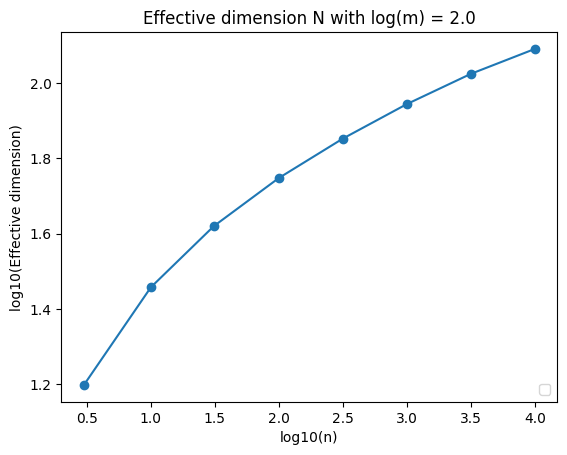

In [ ]:
log_m_max = 4 #4 runs in 1min on GPU
m_list, n_list_m, eff_list_m = Effective_Dimension(log_m_max, 4, 1, s, L, domain, PDE, device)

plot_effective_dim_1d(m_list, n_list_m, eff_list_m)
save(m_list, n_list_m, eff_list_m, "eff_dim_heat_sq")

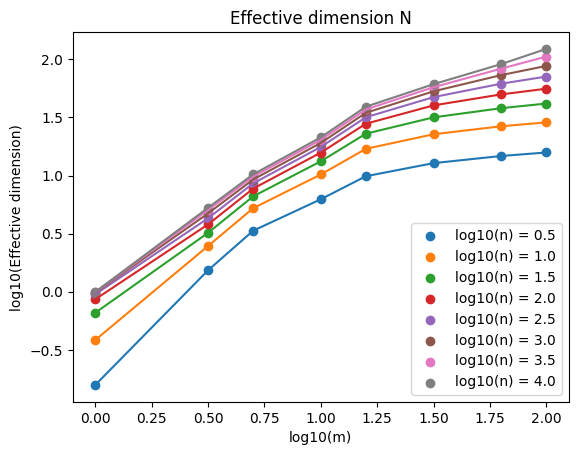

In [ ]:
plot_effective_dim_1d2(m_list, n_list_m, eff_list_m)

### Laplacian on the square

The algorithm is running on GPU.
1 Fourier modes, done.
9 Fourier modes, done.
25 Fourier modes, done.
81 Fourier modes, done.
289 Fourier modes, done.
961 Fourier modes, done.
3249 Fourier modes, done.
10201 Fourier modes, done.


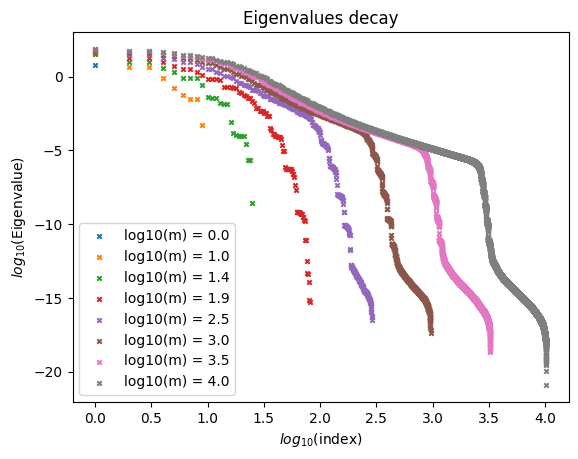

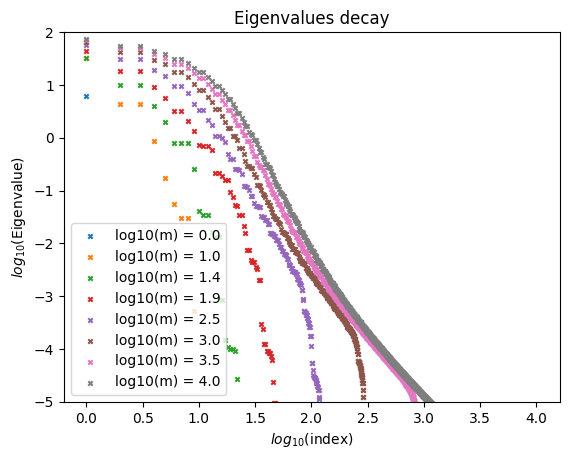

In [ ]:
s = 2
L = torch.pi
domain =  "square"

dX = DifferentialOperator({(1, 0): 1})
dY = DifferentialOperator({(0, 1): 1})
PDE = dX**2 + dY**2

log_m_max = 4
lambda_n, mu_n = 1/100, 1

m_list, xs, spectra = Eigenvalues_numerical(log_m_max, lambda_n, mu_n, s, L, domain, PDE, device)
plot_eigenvalues(m_list, xs, spectra, ymin = -5, ymax =2)

1 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
9 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
25 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
81 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
289 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
961 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
3249 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
10201 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done


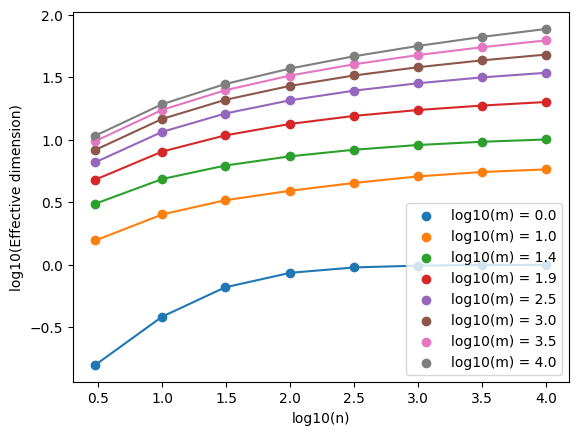

In [ ]:
log_m_max = 4
m_list, n_list_m, eff_list_m = Effective_Dimension(log_m_max, 4, 1, s, L, domain, PDE, device)
plot_effective_dim(m_list, n_list_m, eff_list_m)

### Laplacian on the disk

The algorithm is running on GPU.
1 Fourier modes, done.
9 Fourier modes, done.
25 Fourier modes, done.
81 Fourier modes, done.
289 Fourier modes, done.
961 Fourier modes, done.
3249 Fourier modes, done.
10201 Fourier modes, done.


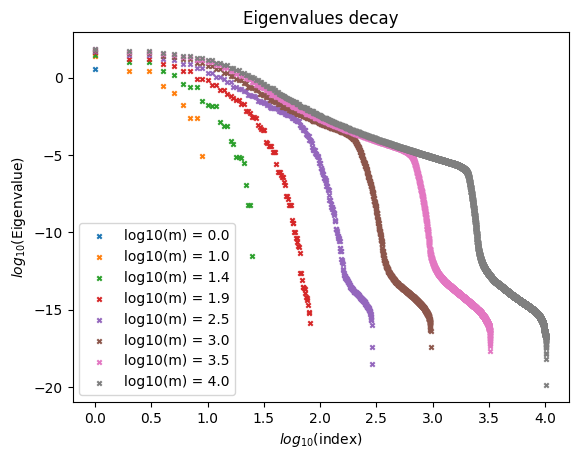

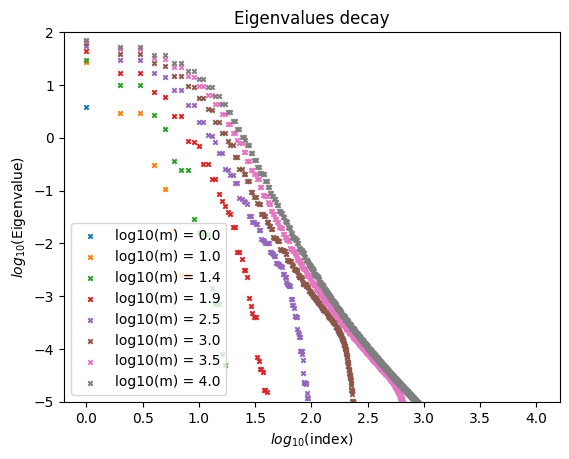

In [ ]:
s = 2
L = torch.pi
domain =  "disk"

dX = DifferentialOperator({(1, 0): 1})
dY = DifferentialOperator({(0, 1): 1})
PDE = dX**2 + dY**2

log_m_max = 4 #Sur GPU, log = 4 tourne en moins de 20 secondes, 4.5 dépasse la mémoire RAM de 7 giga
lambda_n, mu_n = 1/100, 1

m_list, xs, spectra = Eigenvalues_numerical(log_m_max, lambda_n, mu_n, s, L, domain, PDE, device)
plot_eigenvalues(m_list, xs, spectra, ymin = -5, ymax =2)

1 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
9 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
25 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
81 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
289 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
961 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
3249 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
10201 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done


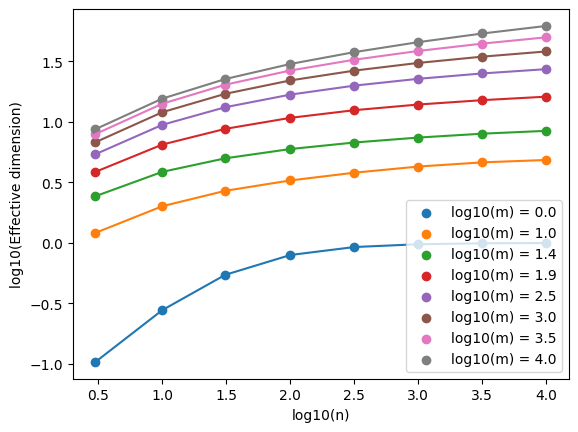

In [ ]:
log_m_max = 4 #4 runs in 1min on GPU
m_list, n_list_m, eff_list_m = Effective_Dimension(log_m_max, 4, 1, s, L, domain, PDE, device)
plot_effective_dim(m_list, n_list_m, eff_list_m)

### Wave on the square

The algorithm is running on GPU.
1 Fourier modes, done.
9 Fourier modes, done.
25 Fourier modes, done.
81 Fourier modes, done.
289 Fourier modes, done.
961 Fourier modes, done.
3249 Fourier modes, done.


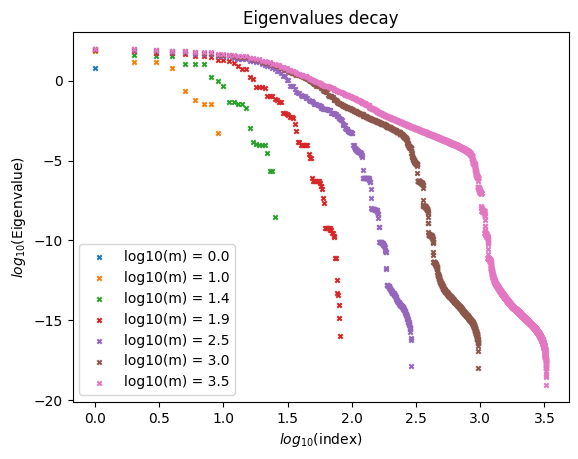

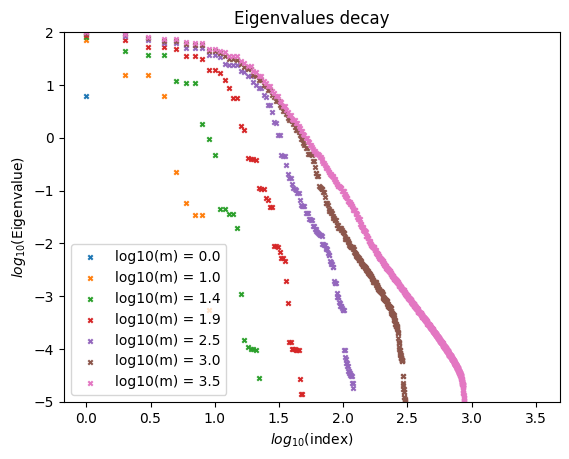

In [ ]:
s = 2
L = torch.pi
domain =  "square"

dX = DifferentialOperator({(1, 0): 1})
dY = DifferentialOperator({(0, 1): 1})
PDE = dX**2 - dY**2

log_m_max = 3.5 #Sur GPU, log = 4 tourne en moins de 20 secondes, 4.5 dépasse la mémoire RAM de 7 giga
lambda_n, mu_n = 1/100, 1

m_list, xs, spectra = Eigenvalues_numerical(log_m_max, lambda_n, mu_n, s, L, domain, PDE, device)
plot_eigenvalues(m_list, xs, spectra, ymin = -5, ymax =2)

1 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
9 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
25 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
81 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
289 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
961 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done
3249 Fourier modes
12.5% done
25.0% done
37.5% done
50.0% done
62.5% done
75.0% done
87.5% done
100.0% done


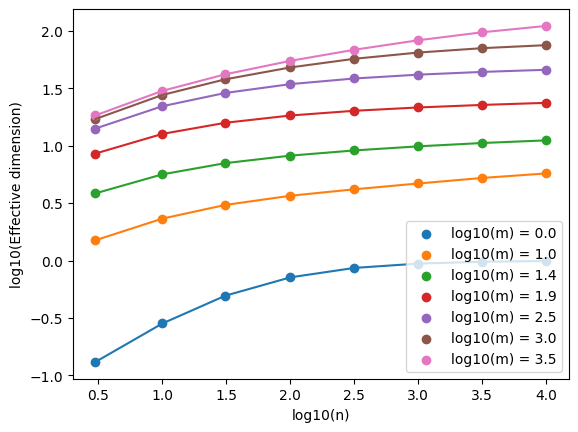

In [ ]:
log_m_max = 3.5 #4 runs in 1min on GPU
m_list, n_list_m, eff_list_m = Effective_Dimension(log_m_max, 4, 1, s, L, domain, PDE, device)
plot_effective_dim(m_list, n_list_m, eff_list_m)

## Performance of the physics-informed kernel

### Hybrid modelling : heat equation

Hybrid modelling: $\lambda_n = n^{-4/5}/10, \mu_n = 10n^{-2/3}$.

Strong PDE : $\lambda_n = n^{-4/5}/10, \mu_n = 1000$

Sobolev learning : $\lambda_n = n^{-2/3}, \mu_n = 0$

In [ ]:
torch.manual_seed(31)

sigma = 0.5
err_coef = 0.5
s=2
L=torch.pi
m=10
l = 1000
domain = "square"

dX = DifferentialOperator({(1, 0): 1})
dY = DifferentialOperator({(0, 1): 1})
PDE = dX - dY**2

torch.manual_seed(31)

samples = []
err_imparf_hybrid = []
err_imparf_PDE = []
err_imparf_Sobolev = []


for exponent in range(6, 31):# 31):
  n = torch.tensor(int(10**(exponent/6))).to(device)

  err_n_hybrid = []
  err_n_PDE = []
  err_n_Sobolev = []

  for sample in range(10):
    data_t = torch.rand(n, device=device)*2*L-L
    data_x = torch.rand(n, device=device)*2*L-L
    data_y = torch.exp(-data_t)*torch.cos(data_x) + err_coef*torch.sin(2*data_x)+torch.normal(torch.zeros(n),sigma*torch.ones(n)).to(device=device)

    data_zt = torch.rand(l, device=device)*2*L-L
    data_zx = torch.rand(l, device=device)*2*L-L
    ground_truth =  torch.exp(-data_zt)*torch.cos(data_zx) + err_coef*torch.sin(2*data_zx)

    lambda_n, mu_n =  0.1*n**(-2/3), (10**2)*n**(-1.)
    regression_vect_hybrid = RFF_fit(data_t, data_x, data_y, s, m, lambda_n, mu_n, L, domain, PDE, device)
    estimator_hybrid = RFF_estimate(regression_vect_hybrid, data_zt, data_zx, s, m, n, lambda_n, mu_n, L, domain, PDE, device)

    lambda_n, mu_n =  10**-10, 10**10
    regression_vect_PDE = RFF_fit(data_t, data_x, data_y, s, m, lambda_n, mu_n, L, domain, PDE, device)
    estimator_PDE = RFF_estimate(regression_vect_PDE, data_zt, data_zx, s, m, n, lambda_n, mu_n, L, domain, PDE, device)

    lambda_n, mu_n =  0.1*n**(-2/3), 0
    regression_vect_sob = RFF_fit(data_t, data_x, data_y, s, m, lambda_n, mu_n, L, domain, PDE, device)
    estimator_sob = RFF_estimate(regression_vect_sob, data_zt, data_zx, s, m, n, lambda_n, mu_n, L, domain, PDE, device)


    err_n_hybrid.append(torch.sum(torch.square(torch.abs(estimator_hybrid - ground_truth)))/l)
    err_n_PDE.append(torch.sum(torch.square(torch.abs(estimator_PDE - ground_truth)))/l)
    err_n_Sobolev.append(torch.sum(torch.square(torch.abs(estimator_sob - ground_truth)))/l)

  err_imparf_hybrid.append(err_n_hybrid)
  err_imparf_PDE.append(err_n_PDE)
  err_imparf_Sobolev.append(err_n_Sobolev)
  samples.append(n.item())
  print("Step "+str(exponent)+", corresponding to n="+ str(n.item())+", is done.")

Step 6, corresponding to n=10, is done.
Step 7, corresponding to n=14, is done.
Step 8, corresponding to n=21, is done.
Step 9, corresponding to n=31, is done.
Step 10, corresponding to n=46, is done.
Step 11, corresponding to n=68, is done.
Step 12, corresponding to n=100, is done.
Step 13, corresponding to n=146, is done.
Step 14, corresponding to n=215, is done.
Step 15, corresponding to n=316, is done.
Step 16, corresponding to n=464, is done.
Step 17, corresponding to n=681, is done.
Step 18, corresponding to n=1000, is done.
Step 19, corresponding to n=1467, is done.
Step 20, corresponding to n=2154, is done.
Step 21, corresponding to n=3162, is done.
Step 22, corresponding to n=4641, is done.
Step 23, corresponding to n=6812, is done.
Step 24, corresponding to n=10000, is done.
Step 25, corresponding to n=14677, is done.
Step 26, corresponding to n=21544, is done.
Step 27, corresponding to n=31622, is done.
Step 28, corresponding to n=46415, is done.
Step 29, corresponding to n=

alpha = -0.9921249472399095




<ipython-input-22-c9ccb6f0409b>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')


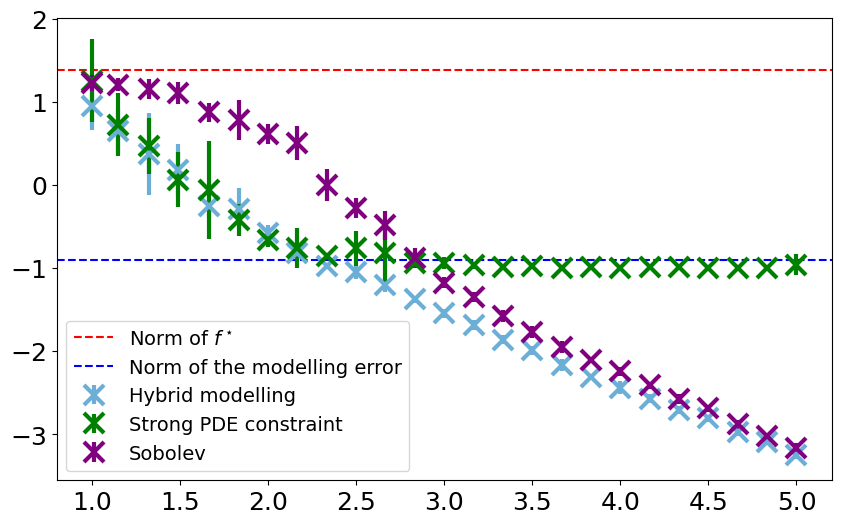

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from matplotlib import cm
from matplotlib import colors

# Font management
font = {'family' : 'sans-serif',
        'size'   : 18}
plt.rc('font', **font)
plt.figure(figsize=(10,6))
cmap = cm.get_cmap('tab20c')


y1_color = cmap(1/20) #bleu
y2_color = cmap(6/20) #orange
y3_color = cmap(9/20) #vert

err_imparf = [[i.cpu() for i in elem] for elem in err_imparf_hybrid]
err_mean = [np.mean(np.log(err_sample))/np.log(10) for err_sample in err_imparf]
err_std = [np.std(np.log(err_sample))/np.log(10) for err_sample in err_imparf]

reg = LinearRegression().fit(np.log(samples).reshape(-1,1)/np.log(10), err_mean)
print("alpha = " + str(reg.coef_[0])+'\n\n')
#x = np.linspace(np.log(samples[0])/np.log(10), np.log(samples[-1])/np.log(10), 1000)
#plt.plot(x, reg.coef_[0]*x + reg.intercept_, linestyle='--', linewidth=3, color=y2_color)


plt.errorbar(np.log(samples)/np.log(10), err_mean, err_std, linestyle='None', marker='x',linewidth=3, color=y1_color, markersize=14,mew=3, label="Hybrid modelling")


plt.axhline(y=np.log(np.mean(np.square(np.array(ground_truth.cpu()))))/np.log(10), color='r', linestyle='--', label="Norm of $f^\star$")
plt.axhline(y=np.log(np.mean(np.square(np.array(err_coef*torch.sin(2*data_zx).cpu()))))/np.log(10), color='b', linestyle='--', label="Norm of the modelling error")


err_imparf = [[i.cpu() for i in elem] for elem in err_imparf_PDE]
err_mean = [np.mean(np.log(err_sample))/np.log(10) for err_sample in err_imparf]
err_std = [np.std(np.log(err_sample))/np.log(10) for err_sample in err_imparf]
plt.errorbar(np.log(samples)/np.log(10), err_mean, err_std, linestyle='None', marker='x',linewidth=3, color='g', markersize=14,mew=3, label="Strong PDE constraint")

err_imparf = [[i.cpu() for i in elem] for elem in err_imparf_Sobolev]
err_mean = [np.mean(np.log(err_sample))/np.log(10) for err_sample in err_imparf]
err_std = [np.std(np.log(err_sample))/np.log(10) for err_sample in err_imparf]
plt.errorbar(np.log(samples)/np.log(10), err_mean, err_std, linestyle='None', marker='x',linewidth=3, color='purple', markersize=14,mew=3, label="Sobolev")


plt.legend(loc='lower left', fontsize=14)
plt.savefig("experiment_heat.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Test en interpolation

Dans la limite $m \geq n$, $\mu_n = 0$ et $\lambda_n \to 0$, comme
$\hat{f}_n(m) = \mathrm{argmin}_{f \in H_m} \frac{1}{n}\sum_{j=1}^n |f(X_i)-Y_i|^2 + \lambda_n \|f\|_{H^s_{per}([-2L,2L]^d)}^2$, on s'attend à interpoler parfaitement.

La dimension effective devient $m$.


In [ ]:
n = 10
m = 10
lambda_n = 10**-7

for i in range(10):
  K = np.random.randn(m,n)
  K = np.transpose(K)@K

  data_x = np.random.rand(n)
  data_y = np.random.rand(n)

  err = np.mean(np.square((K@np.linalg.solve(K + lambda_n*np.eye(n,n), data_y)-data_y)))
  l2norm = np.mean(np.square(data_y))
  print(err/l2norm*100)


3.3340273052988396e-12
1.7834250406356944e-12
1.1991772976604293e-06
3.068521593157983e-08
4.459676559150263e-12
5.9267691838260964e-12
5.126151171306676e-11
3.205793742129108e-11
3.203080521945916e-12
6.0705674907486515e-12


In [ ]:
n = 10
m = 10 #nombre de paramètres réels = (2m+1)**2
lambda_n = 10**-30
mu_n = 0
L=torch.pi
s=2
domain = "square"
dX = DifferentialOperator({(1, 0): 1})
dY = DifferentialOperator({(0, 1): 1})
PDE = dX**2 - dY**2

for i in range(10):
  data_x = torch.rand(n, device=device)*(1+0*1j)
  data_t = torch.rand(n, device=device)*(1+0*1j)
  data_y = torch.rand(n, device=device)*(1+0*1j)

  l = len(data_x)

  mat_t = torch.tile(data_t, ((2*m+1)**2,1))
  mat_x = torch.tile(data_x, ((2*m+1)**2,1))

  fourier_range = torch.arange(-m, m+1, device=device)
  fourier_rangex = torch.arange(l, device=device)

  j1, j2,  k1 = torch.meshgrid( fourier_range, fourier_range, fourier_rangex, indexing='ij')
  j1 = j1.flatten().view((2*m+1)**2, l)
  j2 = j2.flatten().view((2*m+1)**2, l)

  phi_mat = phi_matrix(mat_t, mat_x, j1, j2, L)

  M = M_mat(s, m, lambda_n, mu_n, L, domain, PDE, device)
  Y = phi_mat@data_y
  X = torch.conj_physical(torch.transpose(phi_mat, 0, 1))
  kernel = phi_mat@torch.conj_physical(torch.transpose(phi_mat, 0, 1)) + lambda_n*M

  estimator = X@torch.linalg.solve(kernel, Y)

  err = torch.mean(torch.square((estimator-data_y)))
  l2norm = torch.mean(torch.square(data_y))
  print(err/l2norm*100)

tensor(-1.4322e-24+3.1754e-24j, device='cuda:0')
tensor(-5.1533e-26+9.6399e-26j, device='cuda:0')
tensor(-6.4660e-26+3.1039e-26j, device='cuda:0')
tensor(8.7161e-26-1.9751e-25j, device='cuda:0')
tensor(2.0605e-25-1.7829e-26j, device='cuda:0')
tensor(1.3931e-25-3.6744e-26j, device='cuda:0')
tensor(5.1862e-25+6.7735e-26j, device='cuda:0')
tensor(-1.3014e-24-5.4077e-25j, device='cuda:0')
tensor(1.4022e-25+4.3582e-25j, device='cuda:0')
tensor(-7.1692e-25-1.2311e-24j, device='cuda:0')


In [ ]:
sigma = 0
s=2
L=torch.pi
m=10
domain = "square"

dX = DifferentialOperator({(1, 0): 1})
dY = DifferentialOperator({(0, 1): 1})
PDE = dX**2 - dY**2

lambda_n, mu_n = 10**-30, 0

torch.manual_seed(40)

samples = []
err_imparf = []

for exponent in range(6, 24):
  n = torch.tensor(int(10**(exponent/6))).to(device)


  err_n = []
  for sample in range(10):
    data_t = torch.rand(n, device=device)*2*L-L
    data_x = torch.rand(n, device=device)*2*L-L
    data_y = (data_t-data_x)**2/10+torch.normal(torch.zeros(n),sigma*torch.ones(n)).to(device=device)

    data_zt = data_t
    data_zx = data_x
    ground_truth =  data_y

    regression_vect = RFF_fit(data_t, data_x, data_y, s, m, lambda_n, mu_n, L, domain, PDE, device)
    estimator = RFF_estimate(regression_vect, data_zt, data_zx, s, m, n, lambda_n, mu_n, L, domain, PDE, device)

    err_n.append(torch.mean(torch.square(torch.abs(estimator - ground_truth))))
  err_imparf.append(err_n)
  samples.append(n.item())
  print("Step "+str(exponent)+", corresponding to n="+ str(n.item())+", is done.")

Step 6, corresponding to n=10, is done.
Step 7, corresponding to n=14, is done.
Step 8, corresponding to n=21, is done.
Step 9, corresponding to n=31, is done.
Step 10, corresponding to n=46, is done.
Step 11, corresponding to n=68, is done.
Step 12, corresponding to n=100, is done.
Step 13, corresponding to n=146, is done.
Step 14, corresponding to n=215, is done.
Step 15, corresponding to n=316, is done.
Step 16, corresponding to n=464, is done.
Step 17, corresponding to n=681, is done.
Step 18, corresponding to n=1000, is done.
Step 19, corresponding to n=1467, is done.
Step 20, corresponding to n=2154, is done.
Step 21, corresponding to n=3162, is done.
Step 22, corresponding to n=4641, is done.
Step 23, corresponding to n=6812, is done.


<ipython-input-19-704f6f93edb5>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')


alpha = 6.690384994086053




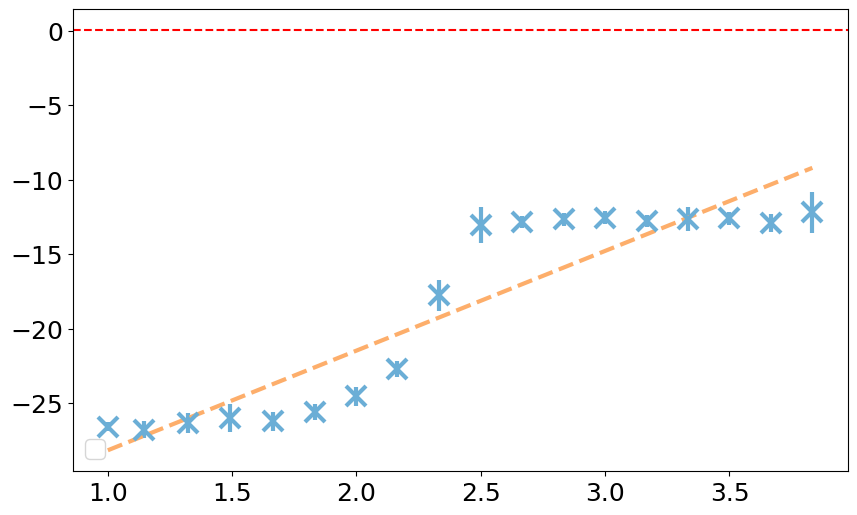

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from matplotlib import cm
from matplotlib import colors

# Font management
font = {'family' : 'sans-serif',
        'size'   : 18}
plt.rc('font', **font)
plt.figure(figsize=(10,6))
cmap = cm.get_cmap('tab20c')


y1_color = cmap(1/20) #bleu
y2_color = cmap(6/20) #orange
y3_color = cmap(9/20) #vert

err_imparf = [[i.cpu() for i in elem] for elem in err_imparf]
err_mean = [np.mean(np.log(err_sample))/np.log(10) for err_sample in err_imparf]
err_std = [np.std(np.log(err_sample))/np.log(10) for err_sample in err_imparf]
samples =samples

reg = LinearRegression().fit(np.log(samples).reshape(-1,1)/np.log(10), err_mean)
print("alpha = " + str(reg.coef_[0])+'\n\n')


plt.errorbar(np.log(samples)/np.log(10), err_mean, err_std, linestyle='None', marker='x',linewidth=3, color=y1_color, markersize=14,mew=3)

x = np.linspace(np.log(samples[0])/np.log(10), np.log(samples[-1])/np.log(10), 1000)
plt.plot(x, reg.coef_[0]*x + reg.intercept_, linestyle='--', linewidth=3, color=y2_color)

plt.axhline(y=np.log(np.mean(np.square(np.array(ground_truth.cpu()))))/np.log(10), color='r', linestyle='--')
plt.legend()
plt.show()